# Sprint
## 深層学習スクラッチ 畳み込みニューラルネットワーク2

## 1.このSprintについて

### Sprintの目的
スクラッチを通してCNNの基礎を理解する

### どのように学ぶか
スクラッチで2次元用畳み込みニューラルネットワークを実装した後、学習と検証を行なっていきます

## 2.2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。


### データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


`(n_samples, n_channels, height, width)`の`NCHW`または`(n_samples, height, width, n_channels)`の`NHWC`どちらかの形にしてください。

-> `NCHW`のほうがよさそう？

In [1]:
# import modules
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import itertools

### 【問題1】
#### 2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値


$i$ : 配列の行方向のインデックス


$j$ : 配列の列方向のインデックス


$m$ : 出力チャンネルのインデックス


$K$ : 入力チャンネル数


$F_h, F_w$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ


$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


$b_m$ : mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$

$\alpha$ : 学習率


$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$に関する損失$L$の勾配


$\frac{\partial L}{\partial b_{m}}$ : $b_m$に関する損失$L$の勾配


勾配$\frac{\partial L}{\partial w_{s,t,k,m}}$や$\frac{\partial L}{\partial b_{m}}$を求めるためのバックプロパゲーションの数式が以下である。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s),(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

$\frac{\partial L}{\partial a_{i,j,m}}$ : 勾配の配列のi行j列、mチャンネルの値


$N_{out,h}, N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$


$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値


$M$ : 出力チャンネル数


ただし、$i−s<0$または$i−s>N_{out,h}−1$または$j−t<0$または$j−t>N_{out,w}−1$のとき$\frac{\partial L}{\partial a_{(i-s),(j-t),m}}=0$です。

### 【問題2】
#### 2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

$N_{out}$ : 出力のサイズ（特徴量の数）


$N_{in}$ : 入力のサイズ（特徴量の数）


$P$ : ある方向へのパディングの数


$F$ : フィルタのサイズ


$S$ : ストライドのサイズ


$h$が高さ方向、$w$が幅方向である

In [2]:
class Conv2d:
    """

    self.W (C_out, C_in, H, W)
    self.B (C_out,)
    """
    def __init__(self, output_ch, input_ch, filter_h, filter_w, lr, stride=1, pad=0):
        self.output_ch = output_ch
        self.input_ch = input_ch
        self.filter_h = filter_h
        self.filter_w = filter_w
        self.lr = lr
        self.stride = stride
        self.pad = pad
        self.W = np.sqrt(2/output_ch) * np.random.randn(output_ch, input_ch, filter_h, filter_w)
        self.B = np.zeros(output_ch)

    def forward(self, X):
        # X (N, C_in, H, W)
        self.X_ = X
        N, C, H, W = X.shape
        self.out_h, self.out_w = calc_out_size(H, W, self.filter_h, self.filter_w, stride=self.stride, pad=self.pad)

        col = im2col(X, self.filter_h, self.filter_w, self.stride, self.pad)
        col_W = self.W.reshape(self.output_ch, -1).T
        # A (N*H*W, C_out)
        A = np.dot(col, col_W) + self.B
        # A (N, H, W, C_out) -> (N, C_out, H, W)
        A = A.reshape(N, self.out_h, self.out_w, -1).transpose(0, 3, 1, 2)

        return A

    def backward(self, dA):
        # dA (N, C_out, H, W)
        
        # dW (C_out, C_in, H, W)
        dW = np.zeros(self.W.shape)
        iterator_dW = itertools.product(range(self.filter_h),
                                        range(self.filter_w),
                                        range(self.input_ch),
                                        range(self.output_ch))
        for s, t, k, m in iterator_dW:
            dW[m, k, s, t] = np.sum(dA[:, m, 0:self.out_h, 0:self.out_w] * self.X_[:, k, s:s+self.out_h, t:t+self.out_w])
        
        # dB (C_out,)
        dB = np.sum(dA, axis=(0, 2, 3))

        # dX (N, C_in, H, W)
        dX = np.zeros(self.X_.shape)
        iterators_dX = itertools.product(range(self.filter_h),
                                         range(self.filter_w),
                                         range(self.filter_h),
                                         range(self.filter_w),
                                         range(self.input_ch),
                                         range(self.output_ch))
        for i, j, s, t, k, m in iterators_dX:
            # 全バッチ分まとめて計算
            if (i-s < 0) or (i-s > self.out_h-1) or (j-t < 0) or (j-t > self.out_w-1):
                continue
            else:
                dX[:, k, i, j] += dA[:, m, (i-s), (j-t)] * self.W[m, k, s, t]

        # update W/B
        self.W = self.W - self.lr*dW/dA.shape[0]
        self.B = self.B - self.lr*dB/dA.shape[0]

        return dX

In [3]:
def calc_out_size(input_h, input_w, filter_h, filter_w, stride, pad):
    out_h = (input_h + 2*pad - filter_h)//stride + 1
    out_w = (input_w + 2*pad - filter_w)//stride + 1
    return (out_h, out_w)

In [4]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h, out_w = calc_out_size(H, W, filter_h, filter_w, stride, pad)

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [5]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h, out_w = calc_out_size(H, W, filter_h, filter_w, stride, pad)
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

### 【問題3】
#### 最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。$S_h \times S_w$の範囲内の行（p）と列（q）


$S_h, S_w$ : 高さ方向（h）と幅方向（w）のストライドのサイズ


$(p,q)\in P_{i,j}$ : $P_{i,j}$に含まれる行（p）と列（q）のインデックス


$a_{i,j,k}$ : 出力される配列のi行j列、kチャンネルの値


$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値


ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス$(p, q)$を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。



In [6]:
class MaxPool2D:
    
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    
    def forward(self, X):
        ## C_in = C_out?
        # X (N, C_in, H, W)
        N, C, H, W = X.shape
        self.input_shape = (N, C, H, W)
        out_h, out_w = calc_out_size(H, W, self.pool_h, self.pool_w, stride=self.stride, pad=self.pad)
        
        col = im2col(X, self.pool_h, self.pool_w, self.stride, self.pad)
        # col (-1, pool_h*pool_w)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # index保存
        self.max_index = np.argmax(col, axis=1)

        out = np.max(col, axis=1)

        # out (N, C_out, H, W)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out
    
    def backward(self, dX):
        # dX (N, C, H, W)
        dX = dX.transpose(0, 2, 3, 1)

        pool_size = self.pool_h * self.pool_w 
        
        dmax = np.zeros((dX.size, pool_size))
        # 最大値を取るindexに誤差を代入
        dmax[np.arange(self.max_index.size), self.max_index.flatten()] = dX.flatten()
        dmax = dmax.reshape(dX.shape + (pool_size,))
        
        dcol = dmax.reshape(dmax.shape[0]*dmax.shape[1]*dmax.shape[2], -1)
        dX_reshaped = col2im(dcol, self.input_shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dX_reshaped

In [7]:
a = np.array([[1,2,3],[4,3,2], [6,5,4], [3,4,5], [6,7,5]])
print(a)
print(a[range(a.shape[0]), np.argmax(a, axis=1)])

[[1 2 3]
 [4 3 2]
 [6 5 4]
 [3 4 5]
 [6 7 5]]
[3 4 6 5 7]


### 【問題4】
#### （アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

In [8]:
class AveragePool2D:
    pass

### 【問題5】
#### 平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [9]:
class Flatten:
    """
    (N, C_out, H, W)を(N, C_out*H*W)にする
    """
    def __init__(self):
        pass

    def forward(self, X):
        self.input_shape = X.shape

        out = X.reshape(self.input_shape[0], -1)

        return out

    def backward(self, dX):
        dX_reshaped = dX.reshape(self.input_shape)

        return dX_reshaped

In [10]:
a = np.array([[[[1,2],[3,4]],[[5,6],[7,8]]],[[[9,10],[11,12]],[[13,14],[15,16]]]])
b = a.reshape(a.shape[0], -1)
print(a)
print(b)
print(b.reshape(a.shape))

[[[[ 1  2]
   [ 3  4]]

  [[ 5  6]
   [ 7  8]]]


 [[[ 9 10]
   [11 12]]

  [[13 14]
   [15 16]]]]
[[ 1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16]]
[[[[ 1  2]
   [ 3  4]]

  [[ 5  6]
   [ 7  8]]]


 [[[ 9 10]
   [11 12]]

  [[13 14]
   [15 16]]]]


## 3.検証

### 【問題6】
#### 学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

DNN実装を拝借する

In [11]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス

    Attribute
    --------
    self.W : ndarray(n_nodes1, n_nodes2)
      重み
    self.B : ndarray(n_node2,)
      バイアス
    self.H : float
      前イテレーションまでの勾配の二乗和
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.HW = np.zeros(self.W.shape)
        self.HB = np.zeros(self.B.shape)
        pass

    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X_ = X

        A = X@self.W + self.B

        return A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        # 更新
        dZ = self.optimizer.update(self, dA)

        return dZ

In [12]:
class Softmax:
    """
    ソフトマックス関数

    Attribute
    ----------
    self.loss
        出力の交差エントロピー誤差
    """
    def forward(self, A):
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        
        return Z

    def backward(self, Z, Y):
        dA = Z - Y
        self.loss = self.calc_cross_entropy_loss(Y, Z)

        return dA
    
    def calc_cross_entropy_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]

        cross_entropy_loss = (-1 * (np.sum(y_true*np.log(y_pred)))) / n_samples
 
        return cross_entropy_loss

In [13]:
class ReLU:
    """
    ReLU関数

    Attribute
    ----------
    self.A
        活性化関数の入力
    """
    def forward(self, A):
        self.pos = A > 0
        Z = self.pos*A
        return Z
    
    def backward(self, dZ):
        if dZ.shape == self.pos.shape:
            dA = self.pos*dZ
        else:
            dA = self.pos*dZ[:, np.newaxis, :]

        return dA

In [14]:
class HeInitializer:
    """
    Heの初期値
    Parameters
    ----------
    n_nodes1 : int
      後の層のノード数

    Attributes
    ----------
    self.sigma
      ガウス分布の標準偏差
    """
    def __init__(self, n_nodes2):
        self.sigma = np.sqrt(2/n_nodes2)
    
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
          重み
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
          バイアス
        """
        B = np.zeros((n_nodes2,))

        return B

In [15]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer, dA):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        dB = np.mean(dA, axis=0)
        dW = (layer.X_.T@dA) / layer.X_.shape[0]
        dZ = dA@layer.W.T

        layer.B = layer.B - self.lr*dB
        layer.W = layer.W - self.lr*dW

        return dZ

In [16]:
class AdaGrad:
    """
    AdaGrad法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer, dA):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        # calc partial
        dB = np.mean(dA, axis=0)
        dW = (layer.X_.T@dA) / dA.shape[0]
        dZ = dA@layer.W.T

        # update HB, HW
        layer.HB = layer.HB + dB**2
        layer.HW = layer.HW + dW**2

        # update W and B
        layer.B = layer.B - self.lr*(1/(np.sqrt(layer.HB+1e-7)))*dB
        layer.W = layer.W - self.lr*(1/(np.sqrt(layer.HW+1e-7)))*dW

        return dZ

一旦

*input -> Conv -> ReLU -> Pooling -> Conv -> ReLU -> Pooling -> Flatten (-> Affine -> ReLU)+ -> Affine -> Softmax*

で試してみる。

In [17]:
class ScratchConvolutionalNeuralNetworkClassifier:
    """
    畳み込みニューラルネットワーク分類器

    Parameters
    ----------
    alpha : float
    sigma : float
    batch_size : int
    epoch : int
    verbose : bool
    output_ch : int
    filter_size : tuple(int, int)
    pooling_size : tuple(int, int)
    stride : int
    pad : int
    n_nodes : list[int...]

    Attributes
    ----------
    self.loss : list
    self.val_loss : list
    """
    def __init__(self, alpha=0.01, sigma=0.01, batch_size=20, epoch=1, verbose=True,
                 output_ch=5, filter_size=(3, 3), pooling_size=(2, 2), stride=1, pad=0, 
                 n_nodes=[20, 10]):
        self.alpha = alpha
        self.sigma = sigma
        self.batch_size = batch_size
        self.epoch = epoch
        self.verbose = verbose
        self.output_ch = output_ch
        self.filter_size = filter_size
        self.stride = stride
        self.pad = pad 
        self.pooling_size = pooling_size
        self.n_nodes = n_nodes

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X (N, C, H, W)
        y (N,)
        X_val (N, C, H, W)
        y_val (N)
        """
        # def optimizer
        optimizer = SGD(self.alpha)

        # def layers
        self.layers = []
        self.input_ch = X.shape[1]
        
        # first layer (Conv2d)
        self.layers.append(Conv2d(math.ceil((self.input_ch+self.output_ch)/2),
                                  self.input_ch,
                                  *self.filter_size,
                                  self.alpha,
                                  stride=self.stride,
                                  pad=self.pad))
        # activator (ReLU)
        self.layers.append(ReLU())

        # pooling (MaxPool2D)
        self.layers.append(MaxPool2D(*self.pooling_size, stride=self.stride, pad=self.pad))

        # calc output size after 1st layer
        output_size_tmp = calc_out_size(*calc_out_size(X.shape[2],
                                                       X.shape[3],
                                                       *self.filter_size,
                                                       self.stride,
                                                       self.pad),
                                        *self.pooling_size,
                                        self.stride,
                                        self.pad)

        # second layer (Conv2d)
        self.layers.append(Conv2d(self.output_ch,
                                  math.ceil((self.input_ch+self.output_ch)/2),
                                  *self.filter_size,
                                  self.alpha,
                                  stride=self.stride,
                                  pad=self.pad))
        # activator (ReLU)
        self.layers.append(ReLU())

        # pooling (MaxPool2D)
        self.layers.append(MaxPool2D(*self.pooling_size, stride=self.stride, pad=self.pad))

        # calc output size after 2nd layer
        self.output_size = calc_out_size(*calc_out_size(*output_size_tmp,
                                                        *self.filter_size,
                                                        self.stride,
                                                        self.pad),
                                         *self.pooling_size,
                                         self.stride,
                                         self.pad)

        # flatten (Flatten)
        self.layers.append(Flatten())

        # calc flatten output size
        self.output_size_flatten = self.output_ch*self.output_size[0]*self.output_size[1]

        for i, (n_nodes1, n_nodes2) in enumerate(zip([self.output_size_flatten]+self.n_nodes[:-1], self.n_nodes)):
            if i+1 != len(self.n_nodes):
                # def initializer
                initializer = HeInitializer(n_nodes2)

                # def layer
                self.layers.append(FC(n_nodes1, n_nodes2, initializer, optimizer))

                # def activator
                self.layers.append(ReLU())
            # last layer
            else:
                # def initializer
                initializer = HeInitializer(n_nodes2)

                # def layer
                self.layers.append(FC(n_nodes1, n_nodes2, initializer, optimizer))

                # def activator
                self.layers.append(Softmax())
    
        ## one-hot encoding
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(y[:, np.newaxis])
        if y_val is not None:
            y_val_one_hot = enc.transform(y_val[:, np.newaxis])

        ## loss list
        self.loss = []
        self.val_loss = []

        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print('start learning')

        start_time = time.time()

        # learning
        for e in range(self.epoch):
            print(f'start epoch {e+1}')

            ## mini_batch
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=e)

            ## loss list
            self.loss.append([])

            for i, (mini_X_train, mini_y_train) in enumerate(get_mini_batch):
                ## one-hot encoding
                mini_y_train_one_hot = enc.transform(mini_y_train[:, np.newaxis])
                
                # save output
                output = None
                for layer in self.layers:
                    # forward
                    if output is None:
                        output = layer.forward(mini_X_train)
                    else:
                        output = layer.forward(output)
                    
                ## update weight, bias
                ## append loss
                dLoss = None
                for layer in self.layers[::-1]:
                    # backward
                    if dLoss is None:
                        dLoss = layer.backward(output, mini_y_train_one_hot)
                        ## append loss 
                        self.loss[e].append(layer.loss)
                    else:
                        dLoss = layer.backward(dLoss)

                ## print progress
                if self.verbose:
                    print(f'\r{i+1}/{len(get_mini_batch)} loop finished (train loss: {self.loss[-1][-1]:.5f})', end='')

            ## validation
            if (X_val is not None) and (y_val is not None):
                ### prediction
                output_val = None
                for layer in self.layers:
                    # forward
                    if output_val is None:
                        output_val = layer.forward(X_val)
                    else:
                        output_val = layer.forward(output_val)

                ### append loss
                self.val_loss.append(self.layers[-1].calc_cross_entropy_loss(y_val_one_hot, output_val))

            if self.verbose:
                print(' : Complete!!')
            if y_val is not None:
                print(f'epoch {e+1} valid loss: {self.val_loss[-1]}')

        end_time = time.time()
        elapsed_time = end_time - start_time

        # output loss
        print(f'last train loss: {self.loss[-1][-1]}')

        print(f'Done! elapsed time: {elapsed_time:.5f}s')

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X (N, C, H, W)

        Returns
        -------
            (n_samples, 1)
        """
        # save output
        output = None

        ## forward propagation
        for layer in self.layers:
            if output is None:
                output = layer.forward(X)
            else:
                output = layer.forward(output)

        return np.argmax(output, axis=1)

In [18]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

学習してみる。

In [19]:
# データのロード
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(48000, 1, 28, 28)
(12000, 1, 28, 28)
(10000, 1, 28, 28)


In [20]:
# 学習
params = {
    'alpha':0.03,
    'batch_size':600,
    'epoch':10,
}
scratchCNN = ScratchConvolutionalNeuralNetworkClassifier(**params)
scratchCNN.fit(X_train, y_train, X_val, y_val)

start learning
start epoch 1
80/80 loop finished (train loss: 2.28981) : Complete!!
epoch 1 valid loss: 2.2902247410075045
start epoch 2
80/80 loop finished (train loss: 2.22707) : Complete!!
epoch 2 valid loss: 2.2352515704942677
start epoch 3
80/80 loop finished (train loss: 2.14320) : Complete!!
epoch 3 valid loss: 2.133688112488526
start epoch 4
80/80 loop finished (train loss: 1.95864) : Complete!!
epoch 4 valid loss: 2.016739669745021
start epoch 5
80/80 loop finished (train loss: 1.85012) : Complete!!
epoch 5 valid loss: 1.8802057657758866
start epoch 6
80/80 loop finished (train loss: 1.76317) : Complete!!
epoch 6 valid loss: 1.7434505673405283
start epoch 7
80/80 loop finished (train loss: 1.68991) : Complete!!
epoch 7 valid loss: 1.6129134778774532
start epoch 8
80/80 loop finished (train loss: 1.46026) : Complete!!
epoch 8 valid loss: 1.4871557644513846
start epoch 9
80/80 loop finished (train loss: 1.30993) : Complete!!
epoch 9 valid loss: 1.3673317591812226
start epoch 10


In [21]:
from sklearn.metrics import accuracy_score
y_test_pred = scratchCNN.predict(X_test)
print(y_test_pred)
print(y_test)
print(f'Accuracy: {accuracy_score(y_test, y_test_pred)}')

[7 2 1 ... 4 2 6]
[7 2 1 ... 4 5 6]
Accuracy: 0.5865


In [22]:
from sklearn.metrics import confusion_matrix
conf_m = confusion_matrix(y_test, y_test_pred) 
print(conf_m)
sample_sum = np.sum(conf_m, axis=1)
for i in range(conf_m.shape[0]):
    correct = conf_m[i][i]
    incorrect = sample_sum[i] - correct
    print(f'{i}: {correct}:{incorrect} {correct/sample_sum[i]:.2%}')

[[747   7  60  35  22  12  67  22   1   7]
 [  5 950  40  31   7  30  14  14  39   5]
 [ 59  86 519 136  51  33  45  36  40  27]
 [ 54  18  43 643  11 103  11  28  86  13]
 [ 40  22  46  16 482  23  43 128  88  94]
 [ 28  40  40 169  39 322 116  42  83  13]
 [ 56   9  37  23  15  52 750   4  10   2]
 [ 69  46  38  17  80  13   4 541  35 185]
 [  9  15  36 107  33  92  25  46 555  56]
 [ 38  23  44  33 203  66  10 147  89 356]]
0: 747:233 76.22%
1: 950:185 83.70%
2: 519:513 50.29%
3: 643:367 63.66%
4: 482:500 49.08%
5: 322:570 36.10%
6: 750:208 78.29%
7: 541:487 52.63%
8: 555:419 56.98%
9: 356:653 35.28%


In [23]:
def plot_loss(model):
    loss = model.loss
    val_loss = model.val_loss

    %matplotlib inline

    # エポック単位
    for i in range(model.epoch):
        fig = plt.figure(figsize=(12, 4))
        ax1 = fig.add_subplot(121)
        plt.title(f'cross entropy loss: epoch{i+1}')
        plt.plot(range(len(loss[i])), loss[i], label='loss')
        plt.legend()

        ## 移動平均
        ax2 = fig.add_subplot(122)
        rolling_loss = []
        rolling_val_loss = []
        window_size = 20
        for j in range(len(loss[i])-window_size):
            rolling_loss.append(sum(loss[i][j:j+window_size])/window_size)
        plt.title(f'rolling loss: epoch{i+1}')  
        plt.plot(range(len(rolling_loss)), rolling_loss, label='rolling loss')
        plt.legend()
        plt.show()

    # バリデーション
    if len(val_loss) > 0:
        plt.title('cross entropy loss: validation')
        plt.plot(range(1, len(val_loss)+1), val_loss, label='val_loss')
        plt.legend()
        plt.show()
    
    # 全体
    plt.title('cross entropy loss: all')
    plt.plot(range(len(sum(loss, []))), sum(loss, []), label='loss')
    plt.legend()
    plt.show()

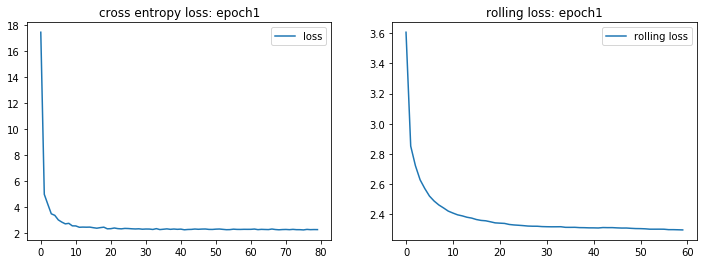

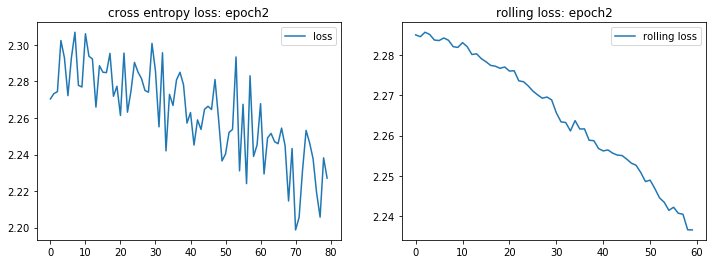

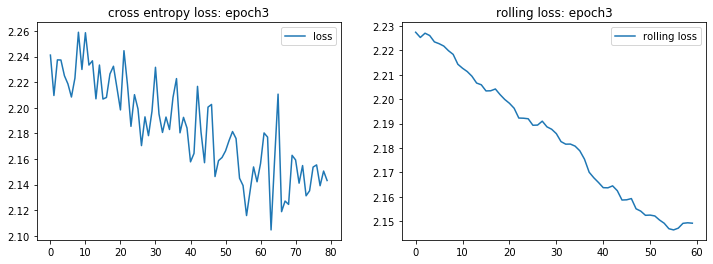

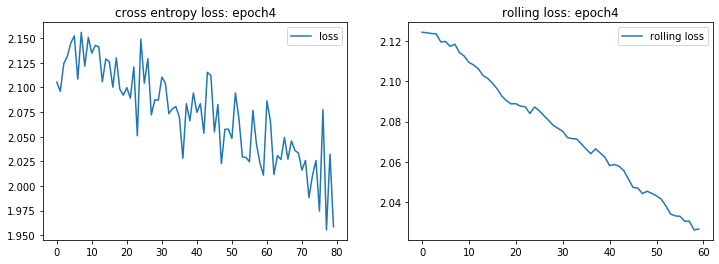

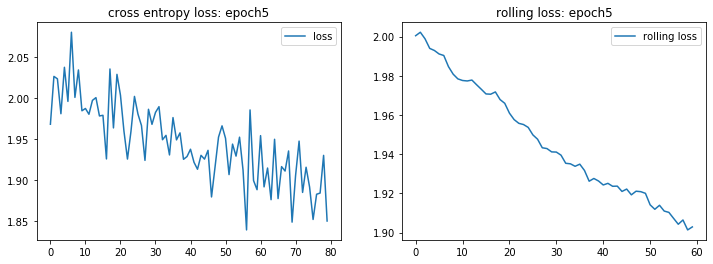

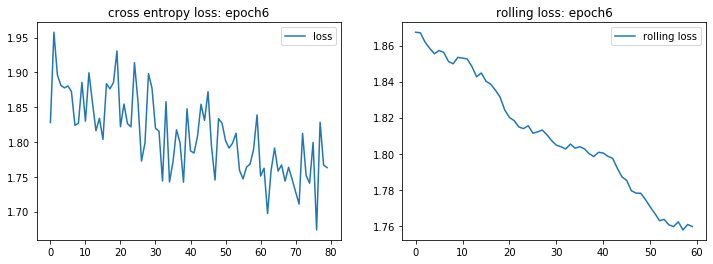

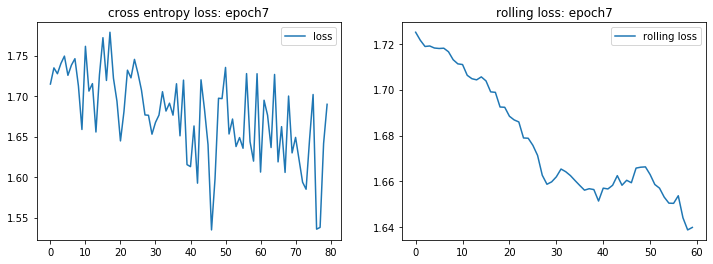

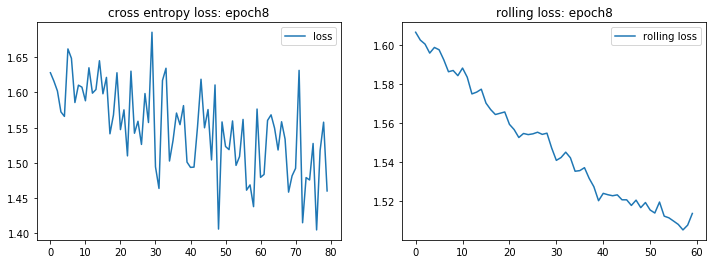

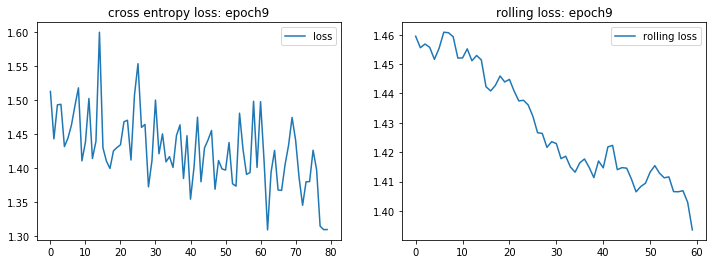

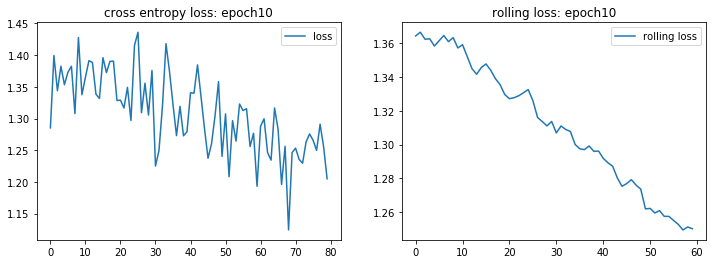

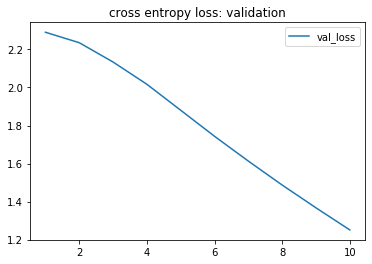

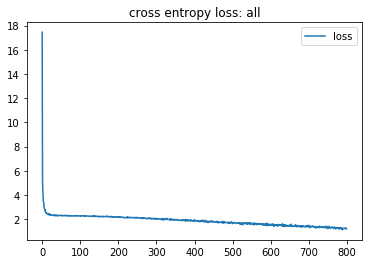

In [24]:
plot_loss(scratchCNN)